In [45]:
# Dependencies and Setup
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
# Dependencies
import csv
import matplotlib.pyplot as plt
import openweathermapy as ow
import pandas as pd
from pprint import pprint
from datetime import date
import json
from datetime import date
import calendar
import seaborn as sns
import matplotlib.ticker as ticker

In [46]:
# Function to plot the bubble graph. It allows for changing the x, y axises and the s (area)
def bubbleplot(df, x_dim, y_dim, s_dim, classes):
   x  = df[x_dim]
   y  = df[y_dim]
   s  = df[s_dim]*20
   ct = df[classes]
   unique_city_type = ct.unique()
   ct_colors ={"Theft Over":"#FF7F50", "Robbery":"#76D7EA","Break and Enter":"#FFD700","Assault":"#A10C4D","Auto Theft":"#6195ED"}
   figsize=(10,10)
   fig, ax = plt.subplots(figsize=figsize)

   for i, city_type in enumerate(unique_city_type):
       xi = [x[j] for j  in range(len(x)) if ct[j] == city_type]
       yi = [y[j] for j  in range(len(x)) if ct[j] == city_type]
       si = [s[j] for j  in range(len(x)) if ct[j] == city_type]
       plt.scatter(x=xi, y=yi, s=si, c=ct_colors[city_type], label=str(city_type),
                   alpha=0.8, linewidths=0.5, edgecolors="black")

       #print(f"i = {i} |(xi,yi,si) points = {len(xi)} | city_type = {city_type} ")

   lgnd = plt.legend(frameon=True,title=classes,loc="upper right")
   for handle in lgnd.legendHandles:
       handle.set_sizes([20])

   ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.8)
   ax.set_title('Major Crime Indicator of Toronto Police')
   ax.set_xlabel(f'{x_dim} (Per City)')
   ax.set_ylabel(y_dim)

   note = f"Note:\nCircle size correlates to \n{s_dim}"
   plt.text(0.92, 0.5, note, fontsize=10, transform=plt.gcf().transFigure)

   #print(f"{x_dim} (min:max) ({x.min()}:{x.max()})\n{y_dim} (min:max) ({y.min()}:{y.max()})\n{s_dim} (min:max) ({s.min()}:{s.max()})")
   bubble_file_name = f"Resources/bubbleplot_{s_dim}.png"
   plt.savefig( bubble_file_name, )
   plt.show()

In [47]:
##Read the Data from already processed datafile
MCI_df = pd.read_csv("Resources/MCI_2014_to_2018_full.csv")
MCI_df.reset_index(None)
# Looking only at strikers (ST) to start
MCI_df["occurencedate_weekday"]=pd.to_datetime(MCI_df["occurrencedate"],format="%Y/%m/%d").dt.weekday
MCI_df["occurencedate_dayname"]=pd.to_datetime(MCI_df["occurrencedate"],format="%Y/%m/%d").dt.day_name()
MCI_df["occurence hour of days"]=pd.to_datetime(MCI_df["occurrencedate"],format="%Y/%m/%d").dt.hour
MCI_df["wardname"]=MCI_df['wardname'].str.strip() + ' (' + MCI_df['wardnumber'].astype(str) + ')'
MCI_df.head()

,Unnamed: 0,X,Y,Index_,event_unique_id,occurrencedate,reporteddate,premisetype,ucr_code,ucr_ext,...,Neighbourhood,Lat,Long,ObjectId,wardnumber,wardname,wardmedian,occurencedate_weekday,occurencedate_dayname,occurence hour of days
0,0,-79.539726,43.587093,108141,GO-2015581495,2015-04-08T17:15:00.000Z,2015-04-08T20:26:00.000Z,House,2120,200,...,Long Branch (19),43.587093,-79.539726,99462,6,Etobicoke-Lakeshore (6),66350.0,2,Wednesday,17
1,1,-79.539726,43.587093,151782,GO-2016401191,2016-03-06T15:00:00.000Z,2016-03-07T20:00:00.000Z,House,1430,100,...,Long Branch (19),43.587093,-79.539726,140047,6,Etobicoke-Lakeshore (6),66350.0,6,Sunday,15
2,2,-79.541870,43.587353,2802,GO-20142331978,2014-06-14T20:00:00.000Z,2014-06-20T17:36:00.000Z,Outside,1430,100,...,Long Branch (19),43.587353,-79.541870,2404,6,Etobicoke-Lakeshore (6),66350.0,5,Saturday,20
3,3,-79.541870,43.587353,53266,GO-20151386979,2015-08-13T03:30:00.000Z,2015-08-13T04:04:00.000Z,Outside,1430,100,...,Long Branch (19),43.587353,-79.541870,48420,6,Etobicoke-Lakeshore (6),66350.0,3,Thursday,3
4,4,-79.541870,43.587353,69269,GO-20161489900,2016-08-22T23:45:00.000Z,2016-08-22T23:49:00.000Z,Outside,1420,100,...,Long Branch (19),43.587353,-79.541870,63103,6,Etobicoke-Lakeshore (6),66350.0,0,Monday,23


In [48]:
total_offence = len(MCI_df)
MCI_df_Groupby_Day_and_MCI=MCI_df.groupby(["occurencedate_dayname","occurencedate_weekday","MCI"])["ObjectId"].agg([("MCI count by WeekDay","count")\
                                                                               ]).reset_index("MCI")
MCI_df_Groupby_Day=MCI_df.groupby(["occurencedate_dayname","occurencedate_weekday"])["ObjectId"].agg([("MCI sum by WeekDay","count")\
                                                                               ])




In [49]:
#MCI_df_Group.to_csv("Resources/Group_by_MCI.csv")
MCI_df_Groupby_all=pd.merge(MCI_df_Groupby_Day_and_MCI,MCI_df_Groupby_Day,on=["occurencedate_weekday","occurencedate_dayname"]).reset_index(None)
MCI_df_Groupby_all=MCI_df_Groupby_all.sort_values("occurencedate_weekday")
MCI_df_Groupby_all

,occurencedate_weekday,occurencedate_dayname,MCI,MCI count by WeekDay,MCI sum by WeekDay
9,0,Monday,Theft Over,779,23093
5,0,Monday,Assault,12287,23093
6,0,Monday,Auto Theft,2546,23093
7,0,Monday,Break and Enter,5030,23093
8,0,Monday,Robbery,2451,23093
25,1,Tuesday,Assault,11828,22781
26,1,Tuesday,Auto Theft,2575,22781
29,1,Tuesday,Theft Over,787,22781
27,1,Tuesday,Break and Enter,5057,22781
28,1,Tuesday,Robbery,2534,22781


In [50]:
MCI_df_Groupby_all["avg"]=MCI_df_Groupby_all["MCI count by WeekDay"]/MCI_df_Groupby_all["MCI sum by WeekDay"]*100
MCI_df_Groupby_all=MCI_df_Groupby_all.reset_index(None)

In [51]:
MCI_df_Groupby_Assault=MCI_df_Groupby_all.loc[MCI_df_Groupby_all["MCI"]=="Assault"].reset_index()

In [52]:
MCI_df_Groupby_all

,index,occurencedate_weekday,occurencedate_dayname,MCI,MCI count by WeekDay,MCI sum by WeekDay,avg
0,9,0,Monday,Theft Over,779,23093,3.373317
1,5,0,Monday,Assault,12287,23093,53.206599
2,6,0,Monday,Auto Theft,2546,23093,11.024986
3,7,0,Monday,Break and Enter,5030,23093,21.781492
4,8,0,Monday,Robbery,2451,23093,10.613606
5,25,1,Tuesday,Assault,11828,22781,51.920460
6,26,1,Tuesday,Auto Theft,2575,22781,11.303279
7,29,1,Tuesday,Theft Over,787,22781,3.454633
8,27,1,Tuesday,Break and Enter,5057,22781,22.198323
9,28,1,Tuesday,Robbery,2534,22781,11.123305


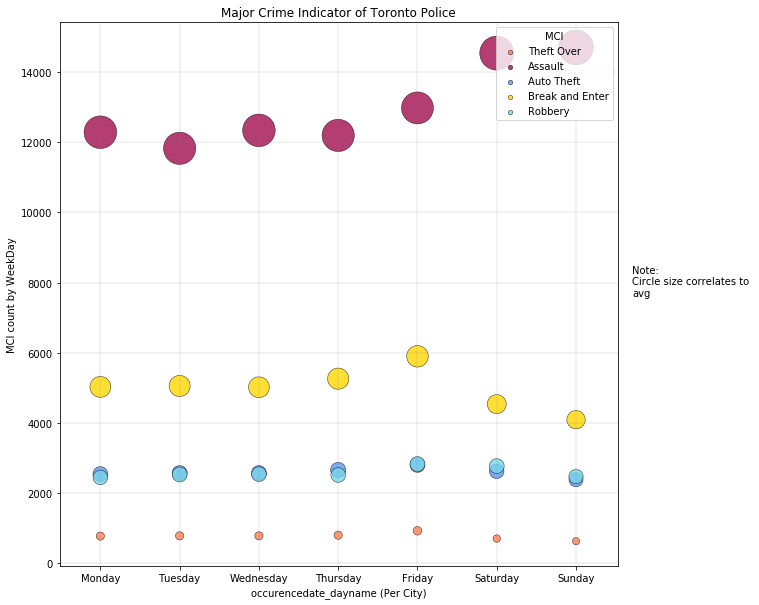

In [53]:
bubbleplot(MCI_df_Groupby_all,"occurencedate_dayname","MCI count by WeekDay","avg","MCI")

In [54]:
# Analysis by ward



MCI_df_Groupby_ward=MCI_df.groupby(["wardnumber","wardname","MCI"])["ObjectId"].agg([("MCI count by ward","count")\
                                                                              ]).join\
(MCI_df.groupby(["wardnumber","wardname","MCI"])["wardmedian"].agg([("Household Median Income","min")\
                                                                              ]))

MCI_df_Groupby_ward

MCI count by ward  \
wardnumber wardname                     MCI                                  
1          Etobicoke North (1)          Assault                       2272   
                                        Auto Theft                     890   
                                        Break and Enter                552   
                                        Robbery                        791   
                                        Theft Over                      96   
2          Etobicoke North (2)          Assault                       1663   
                                        Auto Theft                    1578   
                                        Break and Enter                676   
                                        Robbery                        404   
                                        Theft Over                     210   
3          Etobicoke Centre (3)         Assault                        845   
                                        Auto Theft                     332   
                                        Break and Enter                454   
                                        Robbery                        199   
                                        Theft Over                      51   
4          Etobicoke Centre (4)         Assault                       1037   
                                        Auto Theft                     599   
                                        Break and Enter                705   
                                        Robbery                        267   
                                        Theft Over                      72   
5          Etobicoke-Lakeshore (5)      Assault                       1502   
                                        Auto Theft                     761   
                                        Break and Enter                894   
                                        Robbery                        362   
                                        Theft Over                     249   
6          Etobicoke-Lakeshore (6)      Assault                       2421   
                                        Auto Theft                     364   
                                        Break and Enter                713   
                                        Robbery                        284   
                                        Theft Over                     129   
...                                                                    ...   
39         Scarborough-Agincourt (39)   Assault                        676   
                                        Auto Theft                     220   
                                        Break and Enter                535   
                                        Robbery                        221   
                                        Theft Over                      53   
40         Scarborough-Agincourt (40)   Assault                       1338   
                                        Auto Theft                     316   
                                        Break and Enter                690   
                                        Robbery                        303   
                                        Theft Over                      83   
41         Scarborough-Rouge River (41) Assault                       1026   
                                        Auto Theft                     450   
                                        Break and Enter               1005   
                                        Robbery                        368   
                                        Theft Over                     123   
42         Scarborough-Rouge River (42) Assault                       1992   
                                        Auto Theft                     382   
                                        Break and Enter                513   
                                        Robbery                        380   
 

In [55]:
MCI_df_Groupby_ward=MCI_df_Groupby_ward.reset_index(None)#("wardnumber").set_index("MCI")
MCI_df_Groupby_ward=MCI_df_Groupby_ward.set_index("MCI")
#Pivot the tables 
#MCI_df_Groupby_ward_pivot=MCI_df_Groupby_ward.pivot(columns='wardname',values="MCI count by ward")




In [56]:
MCI_df_Groupby_ward

MCI_df_Groupby_ward_pivot=MCI_df_Groupby_ward.pivot(columns='Household Median Income',values="MCI count by ward")

In [57]:
MCI_df_Groupby_ward_pivot

Household Median Income,48445.0,52821.0,52967.0,53939.0,54317.0,56283.0,56856.0,57626.0,58180.0,58202.0,...,75904.0,76002.0,78617.0,80076.0,81839.0,81931.0,82966.0,91360.0,98418.0,112882.0
MCI,,,,,,,,,,,,,,,,,,,,,
Assault,2856,2090,1602,2323,3868,1853,2861,1338,1985,2543,...,2195,1208,1037,1502,845,1093,2267,1548,687,476
Auto Theft,665,211,445,695,464,483,219,316,541,353,...,268,155,599,761,332,263,285,245,240,413
Break and Enter,621,733,496,650,1199,374,556,690,770,702,...,1000,743,705,894,454,561,1017,615,1049,770
Robbery,619,360,396,583,768,314,449,303,441,618,...,543,222,267,362,199,313,443,296,85,119
Theft Over,185,79,72,97,141,79,46,83,159,120,...,147,94,72,249,51,53,126,54,100,86


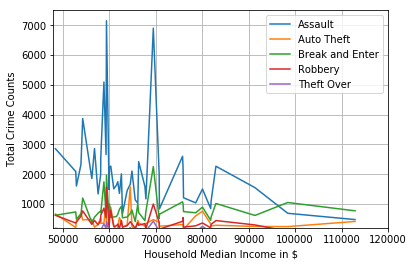

In [58]:

#df=pd.DataFrame({"age":[1,2,3,4,5],"class1":[0.1,0.2,0.3,0.3,0.6],"class2":[0.4,0.1,0.2,0.3,0.6],"class3":[0.1,0.7,0.8,0.3,0.5]})
#df=df.set_index("age")
for i in range(len(MCI_df_Groupby_ward_pivot)):
   plt.plot([k for k in MCI_df_Groupby_ward_pivot.columns],[MCI_df_Groupby_ward_pivot[y].iloc[i] for y in MCI_df_Groupby_ward_pivot.columns])
plt.legend(MCI_df_Groupby_ward_pivot.index,loc="upper right")
plt.xlim(48000,120000)
plt.xlabel("Household Median Income in $")
plt.ylabel("Total Crime Counts")
plt.ylim(200,7500)
plt.grid()
plt.savefig("Resources/Crime Analyis by Household Medain Income.png")
plt.show()










In [59]:
#Time of day analysis of all the crimes
MCI_df_Groupby_hours_and_MCI=MCI_df.groupby(["occurence hour of days","MCI"])["ObjectId"].agg([("MCI count by hours of day","count")\
                                                                            ]).reset_index("MCI")
MCI_df_Groupby_hours=MCI_df.groupby(["occurence hour of days"])["ObjectId"].agg([("MCI sum by hours","count")\
                                                                               ])
#Join both the dataset
MCI_df_Groupby_hours_all=pd.merge(MCI_df_Groupby_hours_and_MCI,MCI_df_Groupby_hours,on=["occurence hour of days"]).reset_index(None)
MCI_df_Groupby_hours_all=MCI_df_Groupby_hours_all.sort_values("occurence hour of days")

MCI_df_Groupby_hours_all["Avg By Hour Of Crime"]=MCI_df_Groupby_hours_all["MCI count by hours of day"]/MCI_df_Groupby_hours_all["MCI sum by hours"]*100
#MCI_df_Groupby_all=MCI_df_Groupby_all.reset_index(None)
MCI_df_Groupby_hours_all

,occurence hour of days,MCI,MCI count by hours of day,MCI sum by hours,Avg By Hour Of Crime
0,0,Assault,5799,10898,53.211598
1,0,Auto Theft,1185,10898,10.873555
2,0,Break and Enter,2331,10898,21.389246
3,0,Robbery,997,10898,9.148468
4,0,Theft Over,586,10898,5.377133
5,1,Assault,4133,7141,57.877048
6,1,Auto Theft,552,7141,7.730010
7,1,Break and Enter,1383,7141,19.367035
8,1,Robbery,957,7141,13.401484
9,1,Theft Over,116,7141,1.624422


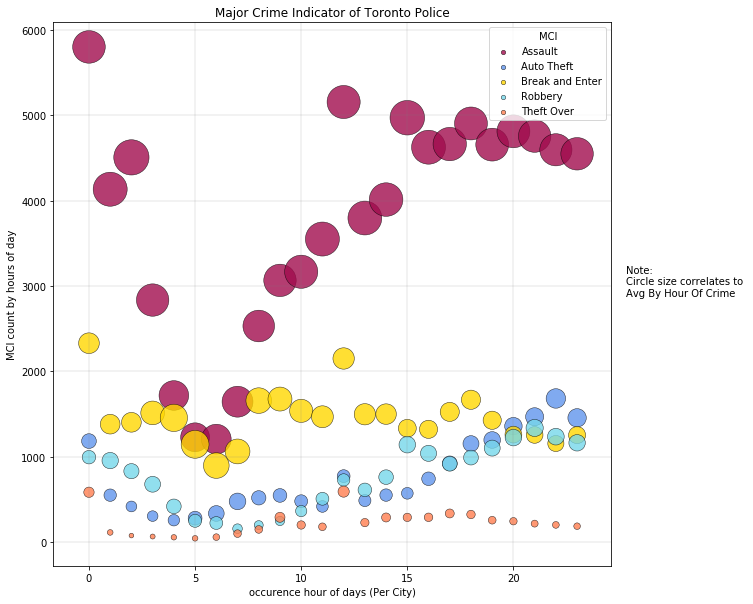

In [60]:
bubbleplot(MCI_df_Groupby_hours_all,"occurence hour of days","MCI count by hours of day","Avg By Hour Of Crime","MCI")

In [61]:

MCI_df_Groupby_hours=MCI_df.groupby(["occurence hour of days","MCI"])["ObjectId"].agg([("MCI count by hour","count")]).reset_index(None)
MCI_df_Groupby_hours=MCI_df_Groupby_hours.set_index("MCI")
MCI_df_Groupby_hours
MCI_df_Groupby_hours_pivot=MCI_df_Groupby_hours.pivot(columns='occurence hour of days',values="MCI count by hour")
MCI_df_Groupby_hours_pivot

occurence hour of days,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
MCI,,,,,,,,,,,,,,,,,,,,,
Assault,5799,4133,4506,2836,1719,1230,1208,1646,2532,3066,...,4012,4970,4625,4662,4903,4655,4811,4755,4595,4548
Auto Theft,1185,552,420,307,259,283,338,479,521,549,...,553,574,744,924,1155,1198,1360,1470,1684,1457
Break and Enter,2331,1383,1405,1515,1457,1147,899,1064,1659,1677,...,1501,1335,1323,1527,1669,1429,1261,1257,1157,1255
Robbery,997,957,833,680,421,252,226,160,202,250,...,763,1143,1042,920,992,1103,1226,1339,1237,1165
Theft Over,586,116,79,68,59,47,61,102,151,293,...,291,292,293,338,326,259,247,219,204,189


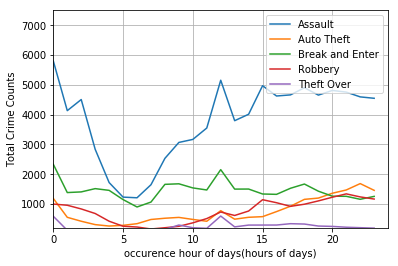

In [62]:
for i in range(len(MCI_df_Groupby_hours_pivot)):
   plt.plot([k for k in MCI_df_Groupby_hours_pivot.columns],[MCI_df_Groupby_hours_pivot[y].iloc[i] for y in MCI_df_Groupby_hours_pivot.columns])
plt.legend(MCI_df_Groupby_hours_pivot.index,loc="upper right")
plt.xlim(0,24)
plt.xlabel("occurence hour of days(hours of days)")
plt.ylabel("Total Crime Counts")
plt.ylim(200,7500)
plt.grid()
plt.savefig("Resources/occurance based on hours of day.png")
plt.show()



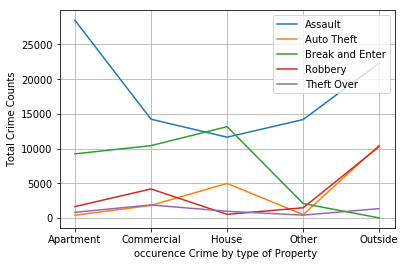

In [63]:
# Plot the premise type of 
MCI_df_Groupby_premisetype=MCI_df.groupby(["premisetype","MCI"])["ObjectId"].agg([("MCI count by premise type","count")]).reset_index(None)
MCI_df_Groupby_premisetype=MCI_df_Groupby_premisetype.set_index("MCI")

MCI_df_Groupby_premisetype_pivot=MCI_df_Groupby_premisetype.pivot(columns='premisetype',values="MCI count by premise type")

for i in range(len(MCI_df_Groupby_premisetype_pivot)):
   plt.plot([k for k in MCI_df_Groupby_premisetype_pivot.columns],[MCI_df_Groupby_premisetype_pivot[y].iloc[i] for y in MCI_df_Groupby_premisetype_pivot.columns])
plt.legend(MCI_df_Groupby_premisetype_pivot.index,loc="upper right")
plt.xlabel("occurence Crime by type of Property ")
plt.ylabel("Total Crime Counts")
plt.grid()
plt.savefig("Resources/occurance based on premise type.png")
plt.show()
